# Wheat Desease Detection

The dataset comes from the followinf link:
https://drive.google.com/drive/folders/1OHKtwD1UrdmhqxrpQEeF_X_pqKotxRGD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
import cv2
import os 
import pickle
import pathlib
from imutils import paths
from tqdm import tqdm
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import Xception, ResNet152, InceptionV3, NASNetLarge
%matplotlib inline

In [ ]:
# LABELS = set(["Crown and Root Rot", "Healthy Wheat", "Leaf Rust", "Wheat Loose Smut"])

In [ ]:
# dataset = "Images"
# label = "lb.pickle"

In [ ]:
# # load dataset path
# imagePaths = list(paths.list_images(dataset))

In [ ]:
# data = []
# labels = []
# for imagePath in imagePaths:
#     label = imagePath.split(os.path.sep)[-2]
#     if label not in LABELS:
#         continue
    
#     image = cv2.imread(imagePath)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (224, 224))
    
#     data.append(image)
#     labels.append(label)
    

In [ ]:
# data = np.array(data)
# labels = np.array(labels)

In [2]:
DIR = "/Images"
data_dir = pathlib.Path(os.getcwd() + '\\Images')

In [3]:
batch_size = 32
img_height = 224
img_width = 224

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1060 files belonging to 4 classes.
Using 848 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1060 files belonging to 4 classes.
Using 212 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['Crown and Root Rot', 'Healthy Wheat', 'Leaf Rust', 'Wheat Loose Smut']


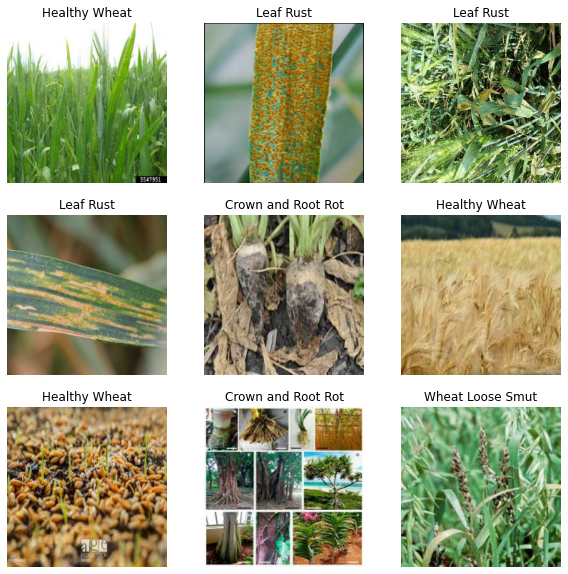

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [9]:
val_batches = tf.data.experimental.cardinality(val_ds)
# test_dataset = val_ds.take(val_batches // 5)
validation_dataset = val_ds.take(val_batches // 1)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
#test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Using data Augumentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2)
])
IMG_SIZE = (224,224)
IMG_SHAPE = IMG_SIZE + (3,)

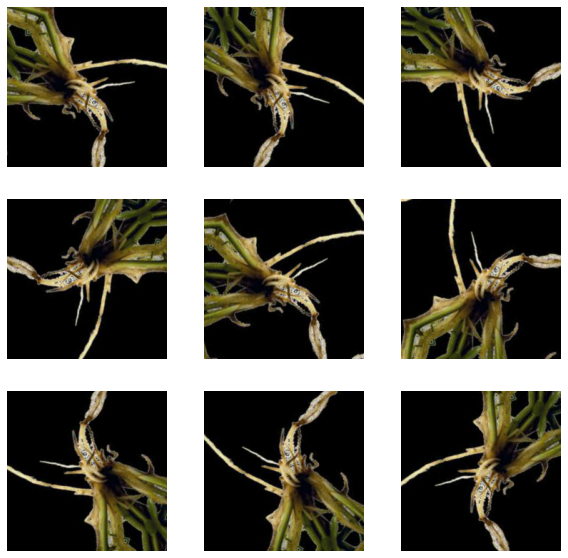

In [13]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Transfer Learning
MobileNet

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [15]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [17]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 6s 327ms/step - loss: 1.6898 - accuracy: 0.2547


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.69
initial accuracy: 0.25


In [23]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset, verbose=0)

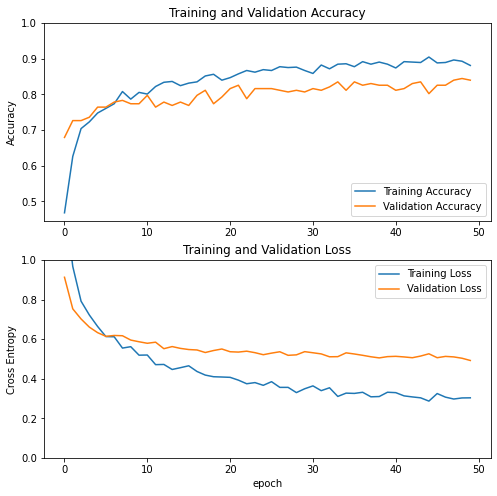

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# VGG19

In [25]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [26]:
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [27]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [28]:
base_model.trainable = False
print(base_model.output)
base_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        

In [29]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(len(class_names))(x)
x = AveragePooling2D(pool_size= (5, 5))(x)
x = Flatten(name = 'flatten')(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(len(class_names), activation = 'softmax')(x)
# final_model = Model(inputs = headmodel.input, outputs = x)
model = tf.keras.Model(inputs, x)

In [30]:
base_learning_rate = 1e-3
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [31]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset, verbose=0)

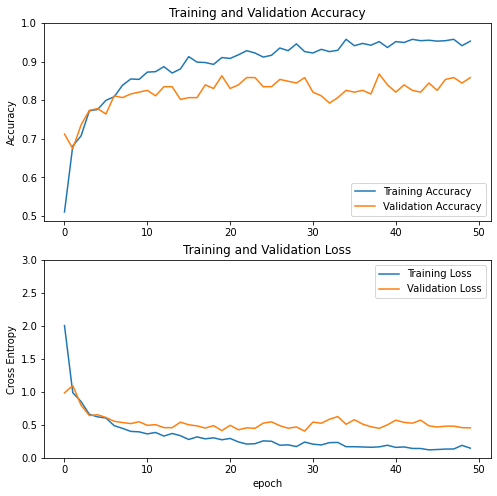

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
Y = np.array([])
yhat = np.array([])
images = np.array([])
for item in val_ds:
    xi, y = item
    pi = np.argmax(model.predict_on_batch(xi),axis = -1)
    #yhat = np.concatenate([yhat, pi])
    Y = np.concatenate([Y, y])
    #print(xi.shape, pi.shape)



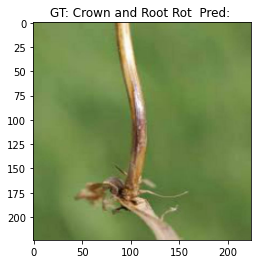

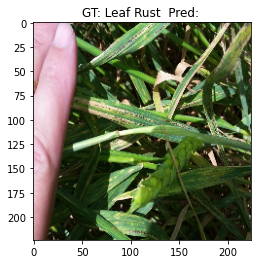

In [34]:
# missclassified images in validation set
XX = xi[pi!=y]
YY = y[pi!=y]
# Y_pred = Y[pi==y]
for i in range(XX.shape[0]):
    img = XX[i]
    img = img.numpy()
    img = img.astype('uint8')
#     plt.imshow(img)
    #img = tf.image.convert_image_dtype(img, tf.float32)
    #img = tf.image.resize(img, [500,500])
    #plt.figure(figsize=(10, 10))
    #ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title('GT: '+ class_names[YY[i]] + '  Pred: ' )
    plt.show()
    #plt.axis('off')

In [ ]:
Y = pi
Y.shape

In [ ]:
tf.math.confusion_matrix(labels=Y, predictions=yhat).numpy()

In [ ]:
headmodel = VGG19(weights = "imagenet", include_top = False,
             input_tensor = Input(shape = (224, 224, 3)))
headmodel.trainable = False
model = headmodel.output
model = AveragePooling2D(pool_size= (5, 5))(model)
model = Flatten(name = 'flatten')(model)
model = Dense(512, activation = 'relu')(model)
model = Dropout(0.2)(model)
model = Dense(len(class_names), activation = 'softmax')(model)

final_model = Model(inputs = headmodel.input, outputs = model)

In [ ]:
opt = Adam(lr = 1e-3)
final_model.compile(loss = "categorical_crossentropy", optimizer = opt,
                   metrics = ["accuracy"])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Xception

In [35]:
preprocess_input = tf.keras.applications.xception.preprocess_input

In [36]:
base_model = Xception(weights = "imagenet", include_top = False)

In [37]:
base_model.trainable = False
print(base_model.output)
base_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 2048), dtype=tf.float32, name=None), name='block14_sepconv2_act/Relu:0', description="created by layer 'block14_sepconv2_act'")
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
bloc

In [40]:
# headmodel = Xception(weights = "imagenet", include_top = False,
#              input_tensor = Input(shape = (299, 299, 3)))
# model = headmodel.output
# model = AveragePooling2D(pool_size= (5, 5))(model)
# model = Flatten(name = 'flatten')(model)
# model = Dense(512, activation = 'relu')(model)
# model = Dropout(0.2)(model)
# model = Dense(len(class_names), activation = 'softmax')(model)

# final_model = Model(inputs = headmodel.input, outputs = model)
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = AveragePooling2D(pool_size= (5, 5))(x)
x = Flatten(name = 'flatten')(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(len(class_names), activation = 'softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [41]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0   

In [43]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset)

Epoch 1/50
27/27 [==============================] - 35s 862ms/step - loss: 1.2182 - accuracy: 0.4752 - val_loss: 0.9355 - val_accuracy: 0.6934
Epoch 2/50
27/27 [==============================] - 14s 493ms/step - loss: 0.9242 - accuracy: 0.6392 - val_loss: 0.8025 - val_accuracy: 0.7075
Epoch 3/50
27/27 [==============================] - 14s 491ms/step - loss: 0.8627 - accuracy: 0.6663 - val_loss: 0.7568 - val_accuracy: 0.7358
Epoch 4/50
27/27 [==============================] - 13s 487ms/step - loss: 0.7796 - accuracy: 0.7146 - val_loss: 0.7280 - val_accuracy: 0.6981
Epoch 5/50
27/27 [==============================] - 13s 488ms/step - loss: 0.7345 - accuracy: 0.7311 - val_loss: 0.7000 - val_accuracy: 0.7170
Epoch 6/50
27/27 [==============================] - 14s 491ms/step - loss: 0.7007 - accuracy: 0.7406 - val_loss: 0.6845 - val_accuracy: 0.7028
Epoch 7/50
27/27 [==============================] - 13s 489ms/step - loss: 0.6851 - accuracy: 0.7665 - val_loss: 0.6627 - val_accuracy: 0.7028

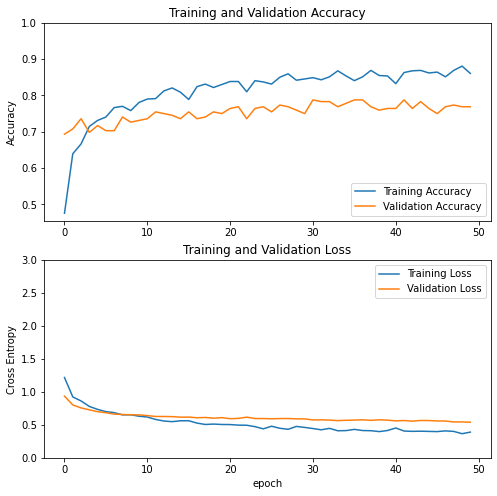

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [46]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = Dropout(0.3)(x)
x = AveragePooling2D(pool_size= (5, 5))(x)
x = Flatten(name = 'flatten')(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.5)(x)
# x = Dense(len(Labels), activation = 'softmax')(model)
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)

In [47]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=validation_dataset)

Epoch 1/30
27/27 [==============================] - 14s 492ms/step - loss: 0.0612 - accuracy: 0.9752 - val_loss: 0.5814 - val_accuracy: 0.8443
Epoch 2/30
27/27 [==============================] - 14s 492ms/step - loss: 0.0601 - accuracy: 0.9835 - val_loss: 0.7100 - val_accuracy: 0.8113
Epoch 3/30
27/27 [==============================] - 14s 495ms/step - loss: 0.1013 - accuracy: 0.9623 - val_loss: 0.5439 - val_accuracy: 0.8396
Epoch 4/30
27/27 [==============================] - 14s 491ms/step - loss: 0.0652 - accuracy: 0.9800 - val_loss: 0.5112 - val_accuracy: 0.8679
Epoch 5/30
27/27 [==============================] - 13s 488ms/step - loss: 0.0471 - accuracy: 0.9882 - val_loss: 0.4914 - val_accuracy: 0.8679
Epoch 6/30
27/27 [==============================] - 13s 489ms/step - loss: 0.0542 - accuracy: 0.9823 - val_loss: 0.4907 - val_accuracy: 0.8585
Epoch 7/30
27/27 [==============================] - 14s 491ms/step - loss: 0.0459 - accuracy: 0.9776 - val_loss: 0.5017 - val_accuracy: 0.8632

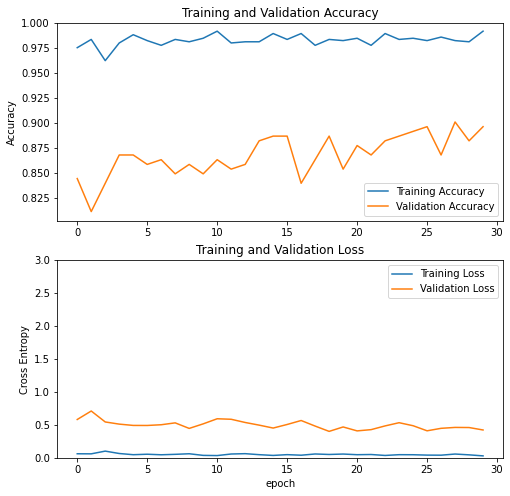

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Applying k fold cross validation
from sklearn.model_selection import KFold



In [ ]:
# evaluate a model using k-fold cross-validation
def evalute_model(dataX, dataY, n_folds= 5):
    # evalute the model using k-fold cv
    scores, hist = list(), list()
    kfold = KFold(n_folds, shuffle= True, random_state= 1)
    # enumurate and split
    for train_i, test_i in kfold.split(dataX):
        # define model
        model = model_define()
        # select data for trainig and testing of each models
        X_train, y_train, X_test, y_test = dataX[train_i], dataY[train_i], dataX[test_i], dataY[test_i]
        # fit model
        history = model.fit(X_train, y_train, batch_size= 32, epochs= 10, validation_data= (X_test, y_test), verbose= 0)
        # evaluate model
        loss, acc = model.evaluate(X_test, y_test, verbose= 0)
        print('>> %3f' % (acc * 100.0))
        #append scores
        scores.append(acc)
        hist.append(history)
    return scores, hist

In [65]:
import numpy as np
from sklearn.model_selection import LeaveOneOut,KFold
import tensorflow as tf
#import tensorflow.contrib.eager as tfe
#tf.enable_eager_execution()
#from sklearn.datasets import load_iris
# data = load_iris()
# X=data['data']
# y=data['target']
def make_dataset(X_data,y_data,n_splits):
    def gen():
        for train_index, test_index in KFold(n_splits).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,y_train,X_test,y_test
    return tf.data.Dataset.from_generator(gen, (tf.float64,tf.float64,tf.float64,tf.float64))
dataset=make_dataset(images,labels,5)

In [74]:
img_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True)

In [76]:
Wheat_data = img_gen.flow_from_directory(data_dir,
                                         subset="training",
                                         seed=123)
images, labels = next(Wheat_data)
print(images.shape)
print(labels.shape)

Found 1060 images belonging to 4 classes.
(32, 256, 256, 3)
(32, 4)


In [73]:
train_gen = img_gen.flow_from_directory(data_dir, subset='training')
val_gen = img_gen.flow_from_directory(data_dir, subset='validation')

Found 849 images belonging to 4 classes.
Found 211 images belonging to 4 classes.


In [ ]:
import glob
from PIL import Image
images = glob.glob("C:/Users/aeska/PycharmProjects/pythonProject1/Wheat Disease Detection/Images/Wheat Loose Smut/*.*")
image_no = 1
for image in images:
    with open(image,"rb") as file:
        img = Image.open(file)
        imgResult = img.resize((800,800), resample = Image.BILINEAR).convert('RGB')
        name = 'C:/Users/aeska/OneDrive/Desktop/a/file_' + str(image_no) + '.jpg'
        imgResult.save(name, 'JPEG')
        image_no += 1
        print("All good")